# Vision Transformer wave function

Authors: Riccardo Rende and Luciano Loris Viteritti, February 2025

The transformer architecture has become the state-of-art model for natural language processing tasks
and, more recently, also for computer vision tasks, thus defining the Vision Transformer (ViT) architecture.
The key feature is the ability to describe long-range correlations among the elements of the input
sequences, through the so-called self-attention mechanism. In this tutorial, we will present the ViT wave function, an adaptation of the ViT
architecture to define a class of variational Neural-Network Quantum States (NQS) for quantum spin
systems (see Ref. [VT23, VIT23]).


We begin by importing the necessary libraries, using [flax](https://github.com/google/flax)'s legacy linen interface for building neural networks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import netket as nk

import jax
import jax.numpy as jnp

print(jax.devices())

import flax
from flax import linen as nn

from einops import rearrange

seed = 0
key = jax.random.key(seed)


[CudaDevice(id=0)]


## ViT architecture

The process of constructing the amplitude corresponding to a physical spin configuration $\boldsymbol{\sigma}$ involves the following steps (see Ref. [VIT23]):

1. *Embedding*
  + The input spin configuration $\boldsymbol{\sigma}$ is initially divided into $n$ patches. The specific shape of the patches depends on the structure of the lattice and its dimensionality, see for example Refs. [VT23, VIT23, RAS24]
  + The patches are linearly projected into a $d$-dimensional embedding space, resulting in a sequence of vectors $(\mathbf{x}_1, \cdots, \mathbf{x}_n)$, where $\mathbf{x}_i \in \mathbb{R}^d$.
2. *Transformer Encoder*
  + A Transformer Encoder with real-valued parameters processes these embedded patches, producing another sequence of vectors $(\mathbf{y}_1, \cdots, \mathbf{y}_n)$, where $\mathbf{y}_i \in \mathbb{R}^d$.
3. *Output layer*
  + The hidden representation $\boldsymbol{z}$ of the configuration $\boldsymbol{\sigma}$ is defined by summing all these output vectors: $\boldsymbol{z}=\sum_{i=1}^n \mathbf{y}_i \in \mathbb{R}^d$.
  + A fully-connected layer with complex-valued parameters maps $\boldsymbol{z}$ to a single complex number, defining the amplitude $\text{Log}[\Psi_{\theta}(\boldsymbol{\sigma})]$ corresponding to the input configuration $\boldsymbol{\sigma}$.

A schematic illustration of the ViT architecture is provided in the following:

![ViTarchitecture](https://s3.gifyu.com/images/bSz0i.gif)


In the first part of this notebook, we implement the Transformer architecture by hand to get through to the smallest details. To be concrete, we consider a spin-$1/2$ system on a two dimensional $L\times L$ square lattice.

## 1. Embedding

We begin by writing a flax module that, given a batch of $M$ spin configurations, first splits each configuration of shape $L\times L$ into $L^2/b^2$ patches of size $b\times b$. Then, each patch is embedded in $\mathbb{R}^d$, with $d$ the *embedding dimension*.


In [ ]:
def extract_patches2d(x, patch_size):
    batch = x.shape[0]
    n_patches = int((x.shape[1] // patch_size**2)**0.5)
    x = x.reshape(batch, n_patches, patch_size, n_patches, patch_size)
    x = x.transpose(0, 1, 3, 2, 4)
    x = x.reshape(batch, n_patches, n_patches, -1)
    x = x.reshape(batch, n_patches*n_patches, -1)
    return x

class Embed(nn.Module):
    d_model : int       # dimensionality of the embedding space
    patch_size: int     # linear patch size
    param_dtype = jnp.float64

    def setup(self):
        self.embed = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), param_dtype=self.param_dtype)

    def __call__(self, x):
        x = extract_patches2d(x, self.patch_size)
        x = self.embed(x)

        return x

In [ ]:
# test embedding module implementation
d_model = 32      # embedding dimension
patch_size = 2    # linear patch size

# initialize a batch of spin configurations, considering a system on a 10x10 square lattice
M = 200
L = 10

key, subkey = jax.random.split(key)
spin_configs = jax.random.randint(subkey, shape=(M, L*L), minval=0, maxval=1) * 2 - 1

print(f"{spin_configs.shape = }")

# initialize the embedding module
embed_module = Embed(d_model, patch_size)

key, subkey = jax.random.split(key)
params_embed = embed_module.init(subkey, spin_configs)

# apply the embedding module to the spin configurations
embedded_configs = embed_module.apply(params_embed, spin_configs)

print(f"{embedded_configs.shape = }")

spin_configs.shape = (200, 100)
embedded_configs.shape = (200, 25, 32)


Working with configurations of shape $10\times 10$ and choosing a patch size of $2\times 2$, the embedding module maps each configuration into a sequence of vectors $(\mathbf{x}_1, \cdots, \mathbf{x}_n)$, with $\mathbf{x}_i \in \mathbb{R}^d$ for all $i$. In the considered setup, the resulting number of vectors is $n=25$ and we have chosen an embedding dimension of $d=32$.

:::{warning}
The function that extracts the patches from the spin configuration must be adapted to the specific lattice geometry. In particular, the function `extract_patches2d` is designed for square lattice without basis.
:::

## 2. Transformer Encoder

The Transformer Encoder block is composed of four ingredients: Multi-Head Attention, two-layer feed-forward neural network, layer normalization and skip connections. These elements are applied sequentially in the Encoder block as represented in the following figure:

![](https://i.ibb.co/V02p9Gst/transformer-encoder.jpg)

In the following we analyze the different building blocks.

### Multi-Head Attention

The core element of the Transformer architecture is the so-called *attention layer*, which processes the sequence of input vectors $(\mathbf{x}_1, \cdots, \mathbf{x}_n)$, with $\mathbf{x}_i \in \mathbb{R}^d$ for all $i$, producing a new sequence $(\boldsymbol{A}_1, \dots, \boldsymbol{A}_n)$, with $\boldsymbol{A}_i \in \mathbb{R}^d$. The goal of this transformation is to construct context-aware output vectors by combining all input vectors (see Ref. [VA17]):

\begin{equation}
    \boldsymbol{A}_i = \sum_{j=1}^n \alpha_{ij}(\boldsymbol{x}_i, \boldsymbol{x}_j) V \boldsymbol{x}_j \ .
\end{equation}

The attention weights $\alpha_{ij}(\boldsymbol{x}_i, \boldsymbol{x}_j)$ form a $n\times n$ matrix, where $n$ is the number of patches, which measure the relative importance of the $j$-$th$ input when computing the new representation of the $i$-$th$ input. To parametrize the ViT wave function, we consider a simplified attention mechanism, called *factored attention* (see Ref. [RM24, SV22]), taking the attention weights only depending on positions $i$ and $j$, but not on the actual values of the spins in these patches. In equations, factored attention leads to $\alpha_{ij}(\boldsymbol{x}_i, \boldsymbol{x}_j)=\alpha_{ij}$. Below, we show how to implement the factored attention module in flax.

In [ ]:
class FactoredAttention(nn.Module):
    n_patches: int   # lenght of the input sequence
    d_model: int     # dimensionality of the embedding space (d in the equations)

    def setup(self):
        self.alpha = self.param("alpha", nn.initializers.xavier_uniform(), (self.n_patches, self.n_patches))
        self.V = self.param("V", nn.initializers.xavier_uniform(), (self.d_model, self.d_model))

    def __call__(self, x):
        y = jnp.einsum('i j, a b, M j b-> M i a', self.alpha, self.V, x)
        return y

For the specific application of approximating ground states of
quantum many-body spin Hamiltonians, factored attention yields equivalent performance with respect to the standard attention mechanism,
while reducing the computational cost and parameter usage (see Ref.[RA25]).

To improve the expressivity of the self-attention mechanism, Multi-Head attention can be considered, where for each position $i$ different attention representations $\boldsymbol{A}_i^{\mu}$ are computed, where $\mu = 1, \dots, h$ with $h$ the total number of heads. The different vectors $\boldsymbol{A}_i^{\mu} \in \mathbf{R}^{d/h}$ are computed in
parallel, concatenated together, and linearly combined through a matrix of weights $W$.

Below we build a flax module that implements the Factored Multi-Head Attention mechanism. In addition, we also provide a translational invariant implementation.

:::{note}
For approximating ground states of translationally invariant Hamiltonians, it is useful to implement translationally invariant attention mechanisms where $\alpha_{ij} = \alpha_{i-j}$.
:::

In [ ]:
from functools import partial
@partial(jax.vmap, in_axes=(None, 0, None), out_axes=1)
@partial(jax.vmap, in_axes=(None, None, 0), out_axes=1)
def roll2d(spins, i, j):
    side = int(spins.shape[-1]**0.5)
    spins = spins.reshape(spins.shape[0], side, side)
    spins = jnp.roll(jnp.roll(spins, i, axis=-2), j, axis=-1)
    return spins.reshape(spins.shape[0], -1)

class FMHA(nn.Module):
    d_model : int       # dimensionality of the embedding space
    n_heads: int        # number of heads
    n_patches: int      # lenght of the input sequence
    transl_invariant: bool = False
    param_dtype = jnp.float64

    def setup(self):
        self.v = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), param_dtype=self.param_dtype)
        self.W = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), param_dtype=self.param_dtype)
        if self.transl_invariant:
            self.alpha = self.param("alpha", nn.initializers.xavier_uniform(), (self.n_heads, self.n_patches), self.param_dtype)
            sq_n_patches = int(self.n_patches**0.5)
            assert sq_n_patches * sq_n_patches == self.n_patches
            self.alpha = roll2d(self.alpha, jnp.arange(sq_n_patches), jnp.arange(sq_n_patches))
            self.alpha = self.alpha.reshape(self.n_heads, -1, self.n_patches)
        else:
            self.alpha = self.param("alpha", nn.initializers.xavier_uniform(), (self.n_heads, self.n_patches, self.n_patches), self.param_dtype)

    def __call__(self, x):
        # apply the value matrix in paralell for each head
        v = self.v(x)

        # split the representations of the different heads
        v = rearrange(v, 'batch n_patches (n_heads d_eff) -> batch n_patches n_heads d_eff', n_heads=self.n_heads)

        # factored attention mechanism
        v = rearrange(v, 'batch n_patches n_heads d_eff -> batch n_heads n_patches d_eff')
        x = jnp.matmul(self.alpha, v)
        x = rearrange(x, 'batch n_heads n_patches d_eff  -> batch n_patches n_heads d_eff')

        # concatenate the different heads
        x = rearrange(x, 'batch n_patches n_heads d_eff ->  batch n_patches (n_heads d_eff)')

        # the representations of the different heads are combined together
        x = self.W(x)

        return x

In [ ]:
# test Factored MultiHead Attention module
n_heads = 8 # number of heads
n_patches = embedded_configs.shape[1] # lenght of the input sequence

# initialize the Factored Multi-Head Attention module
fmha_module = FMHA(d_model, n_heads, n_patches)

key, subkey = jax.random.split(key)
params_fmha = fmha_module.init(subkey, embedded_configs)

# apply the Factored Multi-Head Attention module to the embedding vectors
attention_vectors = fmha_module.apply(params_fmha, embedded_configs)

print(f"{attention_vectors.shape = }")

attention_vectors.shape = (200, 25, 32)


### Encoder Block

In each encoder block, the MultiHead attention mechanism is followed by a two-layers feed-forward neural network. Layer normalization and skip connections are also added to stabilize the training of deep architectures.

In [ ]:
class EncoderBlock(nn.Module):
    d_model : int      # dimensionality of the embedding space
    n_heads: int       # number of heads
    n_patches: int     # lenght of the input sequence
    transl_invariant: bool = False
    param_dtype = jnp.float64

    def setup(self):
        self.attn = FMHA(d_model=self.d_model, n_heads=self.n_heads, n_patches=self.n_patches, transl_invariant=self.transl_invariant)

        self.layer_norm_1 = nn.LayerNorm(param_dtype=self.param_dtype)
        self.layer_norm_2 = nn.LayerNorm(param_dtype=self.param_dtype)

        self.ff = nn.Sequential([
            nn.Dense(4*self.d_model, kernel_init=nn.initializers.xavier_uniform(), param_dtype=self.param_dtype),
            nn.gelu,
            nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), param_dtype=self.param_dtype),
        ])


    def __call__(self, x):
        x = x + self.attn(self.layer_norm_1(x))

        x = x + self.ff( self.layer_norm_2(x) )
        return x

Based on this block, we can implement a module for the full Transformer Encoder applying a sequence of encoder blocks. The number of these blocks is defined by the number of layers of the Transformer architecture.

In [ ]:
class Encoder(nn.Module):
    num_layers: int     # number of layers
    d_model : int       # dimensionality of the embedding space
    n_heads: int        # number of heads
    n_patches: int      # lenght of the input sequence
    transl_invariant: bool = False

    def setup(self):
        self.layers = [EncoderBlock(d_model=self.d_model, n_heads=self.n_heads, n_patches=self.n_patches, transl_invariant=self.transl_invariant) for _ in range(self.num_layers)]

    def __call__(self, x):

        for l in self.layers:
            x = l(x)

        return x

In [ ]:
# test Transformer Encoder module
num_layers = 4 # number of layers

# initialize the Factored Multi-Head Attention module
encoder_module = Encoder(num_layers, d_model, n_heads, n_patches)

key, subkey = jax.random.split(key)
params_encoder = encoder_module.init(subkey, embedded_configs)

# apply the Factored Multi-Head Attention module to the embedding vectors
x = embedded_configs
y = encoder_module.apply(params_encoder, x)

print(f"{y.shape = }")

y.shape = (200, 25, 32)


The Transformer Encoder processes the embedded patches $(\mathbf{x}_1, \cdots, \mathbf{x}_n)$, with $\mathbf{x}_i \in \mathbb{R}^d$, producing another sequence of vectors $(\mathbf{y}_1, \cdots, \mathbf{y}_n)$, with $\mathbf{y}_i \in \mathbb{R}^d$.

## 3. Output layer
For each configuration $\boldsymbol{\sigma}$, we compute its hidden representation $\boldsymbol{z}=\sum_{i=1}^n \mathbf{y}_i$. Then, we produce a single complex number representing its amplitude using the fully-connected layer defined in Ref. [CS17]:

\begin{equation}
    \text{Log}[\Psi(\boldsymbol{\sigma})] = \sum_{\alpha=1}^d \log\cosh \left( b_{\alpha} + \boldsymbol{w}_{\alpha} \cdot \boldsymbol{z} \right) \ ,
\end{equation}

:::{note} 
The parameters $\{ b_\alpha, \boldsymbol{w}_\alpha \}$ are taken to be complex valued, contrary to the parameters of the Transformer Encoder which are all real valued.
:::

In [10]:
log_cosh = nk.nn.activation.log_cosh # Logarithm of the hyperbolic cosine, implemented in a more stable way

class OuputHead(nn.Module):
    d_model : int # dimensionality of the embedding space
    param_dtype = jnp.float64

    def setup(self):
        self.out_layer_norm = nn.LayerNorm(param_dtype=self.param_dtype)

        self.norm2 = nn.LayerNorm(use_scale=True, use_bias=True, param_dtype=self.param_dtype)
        self.norm3 = nn.LayerNorm(use_scale=True, use_bias=True, param_dtype=self.param_dtype)

        self.output_layer0 = nn.Dense(self.d_model, param_dtype=self.param_dtype, kernel_init=nn.initializers.xavier_uniform(), bias_init=jax.nn.initializers.zeros)
        self.output_layer1 = nn.Dense(self.d_model, param_dtype=self.param_dtype, kernel_init=nn.initializers.xavier_uniform(), bias_init=jax.nn.initializers.zeros)

    def __call__(self, x):

        z = self.out_layer_norm(x.sum(axis=1))

        out_real = self.norm2(self.output_layer0(z))
        out_imag = self.norm3(self.output_layer1(z))

        out = out_real + 1j*out_imag

        return jnp.sum(log_cosh(out), axis=-1)

Combining the Embedding, Encoder and OutputHead modules we can implement a module for the full ViT architecture.

In [ ]:
class ViT(nn.Module):
    num_layers: int     # number of layers
    d_model : int       # dimensionality of the embedding space
    n_heads: int        # number of heads
    patch_size: int     # linear patch size
    transl_invariant: bool = False

    @nn.compact
    def __call__(self, spins):
        x = jnp.atleast_2d(spins)

        Ns = x.shape[-1]                        # number of sites
        n_patches = Ns // self.patch_size**2    # lenght of the input sequence

        x = Embed(d_model=self.d_model, 
                  patch_size=self.patch_size)(x)

        y = Encoder(num_layers=self.num_layers, 
                    d_model=self.d_model, 
                    n_heads=self.n_heads, 
                    n_patches=n_patches, 
                    transl_invariant=self.transl_invariant)(x)

        log_psi = OuputHead(d_model=self.d_model)(y)

        return log_psi

In [ ]:
# test ViT module

# initialize the ViT module
vit_module = ViT(num_layers, d_model, n_heads, patch_size)

key, subkey = jax.random.split(key)
params = vit_module.init(subkey, spin_configs)

# apply the ViT module
log_psi = vit_module.apply(params, spin_configs)

print(f"{log_psi.shape = }")

log_psi.shape = (200,)


## Ground state optimization

We show how to train the ViT wave function on the two-dimensional $J_1$- $J_2$ Heisenberg model on a $10\times 10$ square lattice.
The system is described by the following Hamiltonian (with periodic boundary conditions):

$$
    \hat{H} = J_1 \sum_{\langle {\boldsymbol{r}},{\boldsymbol{r'}} \rangle} \hat{\boldsymbol{S}}_{\boldsymbol{r}}\cdot\hat{\boldsymbol{S}}_{\boldsymbol{r'}}
    + J_2 \sum_{\langle \langle {\boldsymbol{r}},{\boldsymbol{r'}} \rangle \rangle} \hat{\boldsymbol{S}}_{\boldsymbol{r}}\cdot\hat{\boldsymbol{S}}_{\boldsymbol{r'}} \ .
$$

We fix $J_2/J_1=0.5$ and we use the VMC_SRt driver (see Ref.[RAS24]) implemented in NetKet to optimize the ViT wave function.

In [ ]:
seed = 0
key = jax.random.key(seed)

L = 10
n_dim = 2
J2 = 0.5

lattice = nk.graph.Hypercube(length=L, n_dim=n_dim, pbc=True, max_neighbor_order=2)

# Hilbert space of spins on the graph
hilbert = nk.hilbert.Spin(s=1/2, N=lattice.n_nodes, total_sz=0)

# Heisenberg J1-J2 spin hamiltonian
hamiltonian = nk.operator.Heisenberg(hilbert=hilbert,
                                    graph=lattice,
                                    J=[1.0, J2],
                                    sign_rule=[False, False]).to_jax_operator() # No Marshall sign rule

# Intiialize the ViT variational wave function
vit_module = ViT(num_layers=4,
                 d_model=60,
                 n_heads=10,
                 patch_size=2,
                 transl_invariant=True)

key, subkey = jax.random.split(key)
params = vit_module.init(subkey, spin_configs)

# Metropolis Local Sampling
N_samples = 4096
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert,
                                        graph=lattice,
                                        d_max=2,
                                        n_chains=N_samples,
                                        sweep_size=lattice.n_nodes)

optimizer = nk.optimizer.Sgd(learning_rate=0.0075)

key, subkey = jax.random.split(key, 2)
vstate = nk.vqs.MCState(sampler=sampler,
                        model=vit_module,
                        sampler_seed=subkey,
                        n_samples=N_samples,
                        n_discard_per_chain=0,
                        variables=params,
                        chunk_size=512)

N_params = nk.jax.tree_size(vstate.parameters)
print('Number of parameters = ', N_params, flush=True)

# Variational monte carlo driver
from netket.experimental.driver.vmc_srt import VMC_SRt
vmc = VMC_SRt(hamiltonian=hamiltonian,
              optimizer=optimizer,
              diag_shift=1e-4,
              variational_state=vstate,
              jacobian_mode="complex")


Number of parameters =  155620


In [14]:
# Optimization
log = nk.logging.RuntimeLog()

N_opt = 800
vmc.run(n_iter = N_opt,
        out=log)

100%|██████████| 800/800 [1:40:04<00:00,  7.51s/it, Energy=-198.581-0.005j ± 0.042 [σ²=7.227]] 


:::{note}
The previous cell requires approximately two hours to run on a single A100 GPU.
:::

We can visualize the training dynamics by plotting the mean energy as a function of the optimization steps:

Last value:  -0.4964522368959598


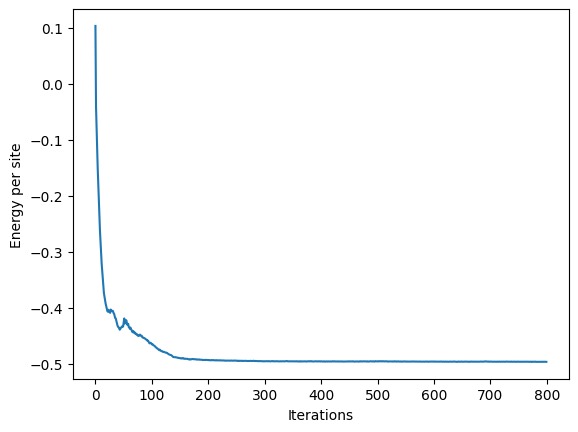

In [16]:
energy_per_site = log.data['Energy']['Mean'].real / (L*L*4)

print("Last value: ", energy_per_site[-1])

plt.plot(energy_per_site)

plt.xlabel("Iterations")
plt.ylabel("Energy per site")

plt.show()

The final variational energy obtained is approximately $E_{\text{var}} \approx -0.4964$. To improve this result, longer simulations with a larger number of samples should be conducted on several GPUs in parallel.

## Pretrained model (Hugging Face)

We provide a pretrained Vision Transformer (ViT) architecture with $P = 434760$ parameters at [Hugging Face ViT](https://huggingface.co/nqs-models/j1j2_square_10x10_05). Below, we demonstrate how the model can be easily downloaded and used within the NetKet framework with just a few lines of code.

In [17]:
from transformers import FlaxAutoModel
wf = FlaxAutoModel.from_pretrained("nqs-models/j1j2_square_10x10", trust_remote_code=True)
N_params = nk.jax.tree_size(wf.params)
print('Number of parameters = ', N_params, flush=True)

Number of parameters =  434760


In [18]:
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert,
                                        graph=lattice,
                                        d_max=2,
                                        n_chains=16384,
                                        sweep_size=lattice.n_nodes)

vstate = nk.vqs.MCState(sampler=sampler,
                        apply_fun=wf.__call__,
                        sampler_seed=subkey,
                        n_samples=16384,
                        n_discard_per_chain=0,
                        variables=wf.params,
                        chunk_size=16384)

# Overwrite samples with already thermalized ones
from huggingface_hub import hf_hub_download
from flax.training import checkpoints
flax.config.update('flax_use_orbax_checkpointing', False)

path = hf_hub_download(repo_id="nqs-models/j1j2_square_10x10", filename="spins")
samples = checkpoints.restore_checkpoint(ckpt_dir=path, prefix="spins", target=None)
samples = jnp.array(samples, dtype='int8') #! some versions of netket do not require this line

vstate.sampler_state = vstate.sampler_state.replace(σ = samples)

E = vstate.expect(hamiltonian)

print(E)

-199.0031+0.0001j ± 0.0099 [σ²=1.5990]


Using a single A100 GPU, the previous cell should run in less than one minute and produce a mean variational energy of approximately $E_{\text{var}} \approx -0.497508$. This energy can be further improved by enforcing lattice symmetries in the variational wavefunction, reaching $E_{\text{var}} \approx -0.497676335$ when restoring translational, point group, and parity symmetries (see [Hugging Face ViT](https://huggingface.co/nqs-models/j1j2_square_10x10_05) for more details).

---

### References

+ [CS17] Carleo, Giuseppe, and Matthias Troyer. "Solving the quantum many-body problem with artificial neural networks." Science 355, no. 6325 (2017): 602-606.
+ [VT23] Viteritti, Luciano Loris, Riccardo Rende, and Federico Becca. "Transformer variational wave functions for frustrated quantum spin systems." Physical Review Letters 130, no. 23 (2023): 236401.
+ [VIT23] Viteritti, Luciano Loris, Riccardo Rende, Alberto Parola, Sebastian Goldt, and Federico Becca. "Transformer wave function for the shastry-sutherland model: emergence of a spin-liquid phase." arXiv preprint arXiv:2311.16889 (2023).
+ [VA17] Vaswani, A. "Attention is all you need." Advances in Neural Information Processing Systems (2017).
+ [RM24] Rende, Riccardo, Federica Gerace, Alessandro Laio, and Sebastian Goldt. "Mapping of attention mechanisms to a generalized Potts model." Physical Review Research 6, no. 2 (2024): 023057.
+ [SV22] S. Jelassi, M. E. Sander, and Y. Li, "Vision transformers provably learn spatial structure", in Advances in neural information processing systems (2022)
+ [RA25] Rende, Riccardo, and Luciano Loris Viteritti. "Are queries and keys always relevant? A case study on transformer wave functions." Machine Learning: Science and Technology 6, no. 1 (2025): 010501.
+ [RAS24] Rende, Riccardo, Luciano Loris Viteritti, Lorenzo Bardone, Federico Becca, and Sebastian Goldt. "A simple linear algebra identity to optimize large-scale neural network quantum states." Communications Physics 7, no. 1 (2024): 260.